# Data Compression with Autoencoders and MNIST

Here, we'll try a slightly more complex example using the MNIST data-set

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
%matplotlib inline

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

print(len(mnist_trainset))

60000


Now that we have our training and test sets loaded, we can define our neural network model:

In [29]:
# define an autoencoder class for MNIST
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            # input is 1 x 28 x 28
            torch.nn.Conv2d(1, 4, kernel_size=5),
            # output is 4 x 24 x 24
            torch.nn.ReLU(True),
            torch.nn.Conv2d(4, 8, kernel_size=5),
            # output is 8 x 20 x 20
            torch.nn.ReLU(True),
            torch.nn.Flatten(),
            # output is 8 x 20 x 20 = 3200
            torch.nn.Linear(3200, 10),
            # output is 10
            torch.nn.ReLU(True)
            )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 400),
            # output is 400
            torch.nn.ReLU(True),
            torch.nn.Linear(400, 4000),
            torch.nn.ReLU(True),
            # output is 4000
            torch.nn.Unflatten(1, (10, 20, 20)),
            # output is 10 x 20 x 20
            torch.nn.ConvTranspose2d(10, 10, kernel_size=5),
            torch.nn.ReLU(True),
            # output is 24 x 24
            torch.nn.ConvTranspose2d(10, 1, kernel_size=5),
            # output is 28 x 28
            torch.nn.Sigmoid()
            )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# define data loaders
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

# define optimizer and loss function
model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()
epoch = 2

# define a training function
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, _ = model(data)
        loss = criterion(recon_batch, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# train the model
for epoch in range(1, epoch + 1):
    train(model, train_loader, optimizer, criterion, epoch)

Selected device: cpu
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.260343
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.112214
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.075598
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.071042
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.060746
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.055009
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.051602
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.039577
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.049133
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.045462
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.041548
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.037801
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.035415
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.033685
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.038464
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.038089
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.030569
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.030509
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.038950
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.

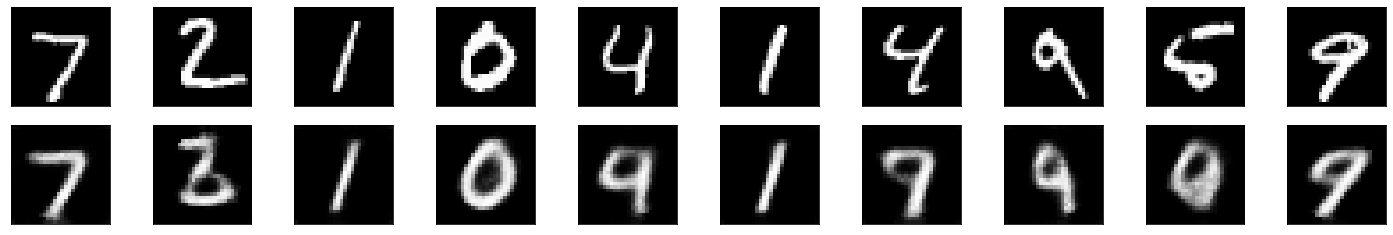

In [30]:
# plot the reconstructed images
dataiter = iter(test_loader)
images, labels = dataiter.next()
recon_images, _ = model(images)
images = images.numpy()
recon_images = recon_images.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([images, recon_images], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

(32, 10)


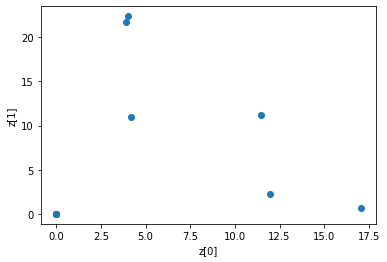

/Users/nimafazeli/Documents/virtual-envs/linear-mixture-model-pyro/virtualenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nimafazeli/Documents/virtual-envs/linear-mixture-model-pyro/virtualenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


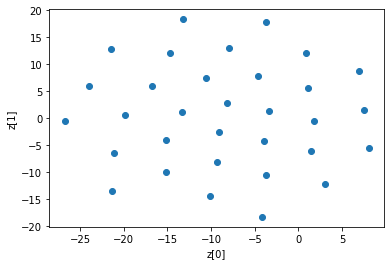

In [35]:
# lets see the latent space
dataiter = iter(test_loader)
images, labels = dataiter.next()
_, z = model(images)
z = z.detach().numpy()
print(z.shape)
fig, ax = plt.subplots()
ax.scatter(z[0, :], z[1, :])
ax.set_xlabel('z[0]')
ax.set_ylabel('z[1]')
plt.show()

# we can also use the t-snse to visualize the latent space
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
z_2d = tsne.fit_transform(z)
fig, ax = plt.subplots()
ax.scatter(z_2d[:, 0], z_2d[:, 1])
ax.set_xlabel('z[0]')
ax.set_ylabel('z[1]')
plt.show()



In [36]:
# lets compute the mean and variance of the latent space vector z
z_mean = np.mean(z, axis=0)
z_var = np.var(z, axis=0)
print(f'z_mean: {z_mean}')
print(f'z_var: {z_var}')

z_mean: [ 0.        0.       14.729536  8.494513 12.213059  9.851475  0.
 13.094073  0.       11.740995]
z_var: [ 0.        0.       36.148655 24.957954 25.64625  58.262142  0.
 31.369915  0.       23.245337]


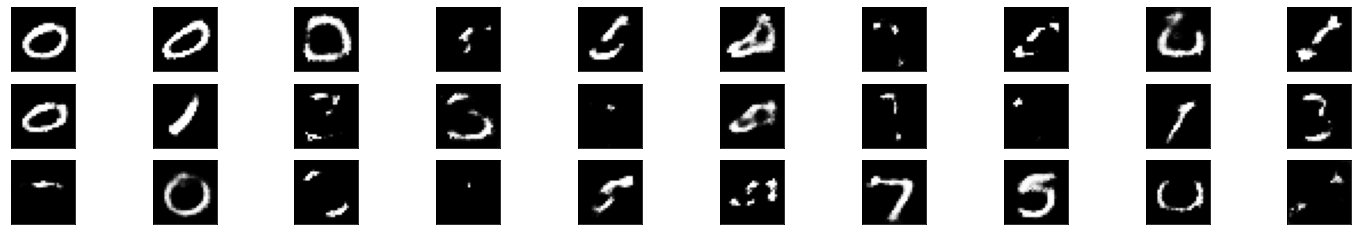

In [70]:
model.eval()
# we can sample from the latent space and reconstruct the images using the mean and variance
z_sample = np.random.normal(z_mean, z_var, size=(2, 10))
z_sample = torch.from_numpy(z_sample).float()

recon_images, _ = model.decoder(z_sample)
recon_images = recon_images.detach().numpy()

fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for col in range(10):
    for row in range(3):
        z_sample = np.random.normal(z_mean, z_var, size=(2, 10))
        z_sample = torch.from_numpy(z_sample).float()

        recon_images, _ = model.decoder(z_sample)
        recon_images = recon_images.detach().numpy()

        axes[row,col].imshow(np.squeeze(recon_images), cmap='gray')
        axes[row,col].get_xaxis().set_visible(False)
        axes[row,col].get_yaxis().set_visible(False)

plt.show()

/Users/nimafazeli/Documents/virtual-envs/linear-mixture-model-pyro/virtualenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


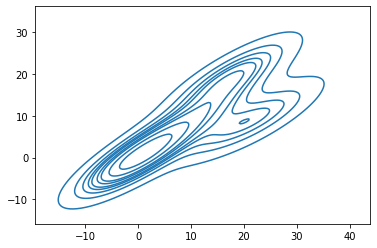

In [73]:
# plot a kde of the latent space vector z for the first 2 dimensions
import seaborn as sns
sns.kdeplot(z[3, :], z[4, :])
plt.show()
